In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


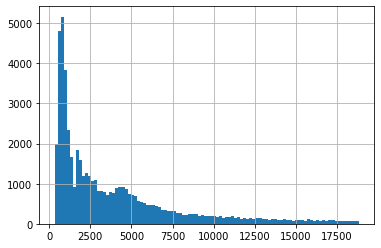

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [7]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [8]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
y_pred = reg.predict(X_test)

In [13]:
score = r2_score(y_pred, y_test)

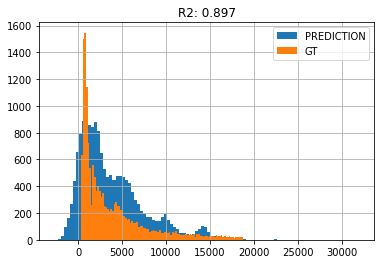

In [14]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [15]:
class Module:
    def forward(self, x):
        pass

    def backward(self, d):
        pass

    def update(self, alpha):
        pass

In [16]:
class Linear(Module):
    def __init__(self, in_features: int, out_features: int):
        self.b = np.zeros(out_features)
        self.w = np.random.randn(in_features, out_features)

        self.dE_dw = None
        self.dE_db = None
        self.vector = False

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.dE_dw = x.T

        if len(x.shape) == 1:
            self.vector = True

        return np.array(self.b + x @ self.w)

    def backward(self, gradient: np.ndarray):
        if self.vector:
            self.dE_dw = np.outer(self.dE_dw, gradient)
        else:
            self.dE_dw = self.dE_dw @ gradient
        self.dE_db = gradient

        return np.array(gradient @ self.w.T)

    def update(self, learning_rate: float):
        self.w = self.w - learning_rate * self.dE_dw
        self.b = self.b - learning_rate * np.sum(self.dE_db, axis=0)

In [17]:
class ReLU(Module):
    def __init__(self):
        self.x = None

    def forward(self, x: np.ndarray):
        self.x = x
        return np.maximum(0, x)

    def backward(self, d):
        return np.array(d * (self.x >= 0).astype(float))

In [18]:
class MLPRegressor:
    def __init__(
            self,
            hidden_layer_sizes=(100,),
            batch_size=10,
            learning_rate=0.001,
            max_iter=10):

        self.hidden_layer_sizes = hidden_layer_sizes
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iter = max_iter

        self.count_input = None
        self.count_output = None
        self.modules = None

        self.batch_y_pred = None
        self.gradient = None

    def get_modules(self):
        self.modules = [Linear(self.count_input, self.hidden_layer_sizes[0]), ReLU()]

        for i in range(len(self.hidden_layer_sizes) - 1):
            self.modules.append(Linear(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i+1]))
            self.modules.append(ReLU())

        self.modules.append(Linear(self.hidden_layer_sizes[-1], self.count_output))

    def train(self, X, y):
        self.count_input = X.shape[1]
        self.count_output = y.shape[1]
        self.get_modules()

        for epoch in range(self.max_iter):
            shuffle_index = np.random.permutation(list(range(X.shape[0])))

            for i in range(X.shape[0] // self.batch_size):
                mask = shuffle_index[i * self.batch_size: i * self.batch_size + self.batch_size]
                self.batch_y_pred, batch_y = X[mask], y[mask]

                # Forward
                for module in self.modules:
                    self.batch_y_pred = module.forward(self.batch_y_pred)

                # Backward
                self.gradient = self.batch_y_pred - batch_y

                for module in self.modules[::-1]:
                    self.gradient = module.backward(self.gradient)

                # Update
                for module in self.modules:
                    module.update(self.learning_rate)

    def predict(self, X):
        y_pred = X
        for module in self.modules:
            y_pred = module.forward(y_pred)

        return y_pred

In [50]:
model = MLPRegressor(hidden_layer_sizes=(6, 3,),
                     batch_size=150,
                     learning_rate=0.001,
                     max_iter=70)

# Проверяем модель MLP на выборке Diamonds

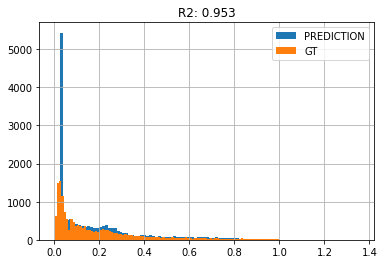

In [53]:
y = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

model.train(X_train, y_train)
y_pred = model.predict(X_test)
plt.title(f'R2: {str(r2_score(y_pred, y_test))[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

Выводы: имплементирован мультислойный перцептрон для задачи регрессии. Построена модель для предсказания цены алмаза. Модель состоит из 4 слоев, 2 из которых - скрытые. На первом внутреннем слое 6 нейронов, на втором - 3. Обучение происходило на нормализованных данных в течение 70 эпох с коэффициентом скорости обучения равным 0.001, размер бэтча - 150. Итоговая модель имеет высокое качество: R2 = 0.953